In [1]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
# !unzip -q kagglecatsanddogs_3367a.zip
# !ls PetImages

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [4]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [5]:
def make_model(input_shape, num_classes, dual=False):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        if dual:
            x = layers.concatenate([layers.MaxPooling2D(3, strides=2, padding="same")(x),
                                    layers.AveragePooling2D(3, strides=2, padding="same")(x)])
            residual = layers.Conv2D(size*2, 1, strides=2, padding="same")(
            previous_block_activation
        )
        else:
            x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
            residual = layers.Conv2D(size, 1, strides=2, padding="same")(
                previous_block_activation
        )
        
        
        # Project residual
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)




In [6]:
model = make_model(input_shape=image_size + (3,), num_classes=2, dual=False)
keras.utils.plot_model(model, show_shapes=True)

epochs = 50
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss='binary_crossentropy',
    metrics=["accuracy"],
)
baseline_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2, dual=True)
keras.utils.plot_model(model, show_shapes=True)

epochs = 50
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss='binary_crossentropy',
    metrics=["accuracy"],
)
dual_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

In [ ]:
import matplotlib.pyplot as plt
def name(var):
    match = [k for k, v in globals().items() if v == var]
    return match[0].replace('_history', '') if match else None

def plot(metric, *history):
    
    getter = metric.replace('train_', '')
    
    for h in history:
        plt.plot(h.history['{}'.format(getter)])
    plt.title('{}, batch size: 32'.format(metric).upper())
    plt.ylabel('{}'.format(metric))
    plt.xlabel('epoch')
    plt.legend(list(map(name, history)), loc='upper left')
    plt.show()

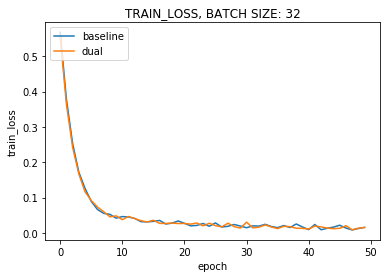

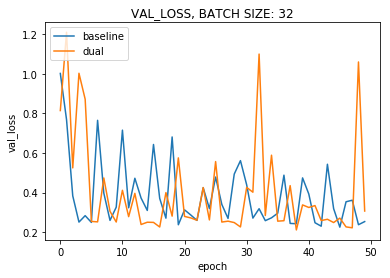

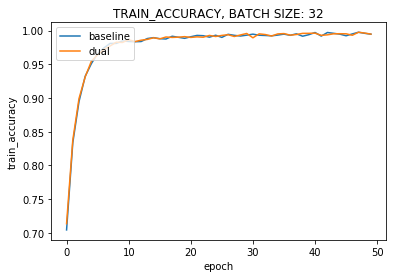

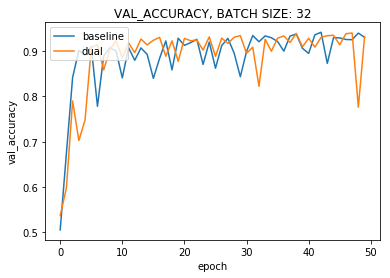

In [11]:
for metric in ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']:
    plot(metric, baseline_history, dual_history)